In [2]:
import os
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
from sklearn.metrics import mean_absolute_error
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)

# suppress pandas warning about operations on copies of dfs
pd.options.mode.chained_assignment = None

## Pull in data, dummify the variables and split into train and test

In [8]:
df = ml_model.canonical_df
df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 1000)]
df = df.loc[(df['rent_per_week'] < 1000)]
brands = df['brand'].value_counts().index
brand_freq = df['brand'].value_counts().values
brand_freq_dict = {brand:freq for brand in brands for freq in brand_freq} 

df_counts = pd.DataFrame(brand_freq, index=brands, columns = ['count'])
most_freq_brands = df_counts[df_counts['count'] > 0].index.values
df_only_top_brands = df[df['brand'].isin(most_freq_brands)]
print(df_only_top_brands.shape)
df_only_top_brands = df_only_top_brands.loc[df_only_top_brands.isnull().any(axis=1) == False]
print(df_only_top_brands.shape)
#df_only_top_brands[df_only_top_brands['brand'] == 'Self-Portrait']
counts = df['brand'].value_counts()
df_only_top_brands['brand_freq'] = df_only_top_brands.apply(lambda row: counts[row['brand']], axis=1)
print(len(most_freq_brands))
print(df_only_top_brands.shape)

(5762, 6)
(5663, 6)
1698
(5663, 7)


### Dummify variables

In [67]:
#df = df.loc[(df['item_type'] == 'dresses') & (df['rent_per_week'] < 100) & (df['rent_per_week'] > 100)]
#df = df.loc[df.isnull().any(axis=1) == False]

df = df_only_top_brands

# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==True]
df_full_test = df[df['is_train']==False]

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
#df = pd.concat([df, dummified_items], axis = 1)

df = df.drop(['item_type', 'brand'], axis = 1)

In [68]:
# get list of adjective features form database
#features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]

features_adj = ['tube', 'sheath', 'blouson', 'tunic', 'pencil', 'asymmetric', 'trench', 'bandage', 'high-low', 'empire',
               'bodycon', 'skater', 'maxi', 'midi', 'mini', 'kaftan', 'shirt', 'off shoulder',
               'sweater', 'tie', 'peplum', 'party', 'backless', 'fringe', 'pop', 'baby', 'a-line', 'layered', 
                'lace-up', 'denim', 'dungaree', 'pinafore', 'cape', 'fit', 'flare', 'shift', 'slit',
                'spaghetti', 't-shirt', 'tulle', 'tuxedo', 'tweed', 'wrap', 'lace', 'cocktail', 'gown', 'runway']

#tokenized_titles = []
#for title in df['title']:
#    parse_title.create_one_hot_row_adj(title, features_adj)
#    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
#df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

tokenized_titles = []
for text_array in df[['title', 'description']].values:
    try:
        text = ' '.join(text_array)
    except TypeError:
        text = title
    tokenized_titles.append(parse_title.create_one_hot_row_adj(text, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj, index = df.index.values)

In [69]:
# used for making sure dfs are the right shape after concatenation
print(df.shape)
print(df_adj.shape)
df_w_adj = pd.concat([df, df_adj], axis = 1)
print(df_w_adj.shape)

(4565, 586)
(4565, 47)
(4565, 633)


In [70]:
final_df = df_w_adj
features = final_df.columns.drop(['rent_per_week', 'title', 'is_train', 'description']) # just column names
train, test = final_df[final_df['is_train']==True], final_df[final_df['is_train']==False]

In [75]:
#clf = svm.SVR() # didn't work. Predicted 43 for everything
reg = RandomForestRegressor(n_jobs=2, n_estimators=10)
#clf.fit(train[features], train['rent_per_week'])
#rfr_predicted = clf.predict(test[features])
#reg = linear_model.LinearRegression() # total crap
#reg = linear_model.Ridge(alpha = 1) # comparable to rfr
#reg = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0]) # comparable to rfr 
#reg = linear_model.Lasso(alpha = 0.1)
#reg = linear_model.ElasticNet(alpha=1) # comparable to rfr 
#reg = linear_model.RANSACRegressor(linear_model.LinearRegression()) # slow, did not finish, uses lots of cpu
#reg = linear_model.TheilSenRegressor() # slow, did not finish, uses lots of cpu
#reg = linear_model.HuberRegressor() # slow, didreg = RandomForestRegressor(n_jobs=2, n_estimators=10) not finish, uses lots of cpu

In [77]:
reg.fit(train[features], train['rent_per_week'].apply(np.log))
predicted = np.exp(reg.predict(test[features]))
                   
# without log
#reg.fit(train[features], train['rent_per_week'])
#predicted = reg.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
#joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
#rfr_predicted
#stopping_value = np.minimum(np.maximum(test['rent_per_week'].values), np.maximum(rfr_predicted))

Slope of regression line for obs v pred:  [ 0.60380994]
mean_absolute_error: 9.676681133840642
R^2:  0.6189288837571252
Length of df_full_test: 1151
403


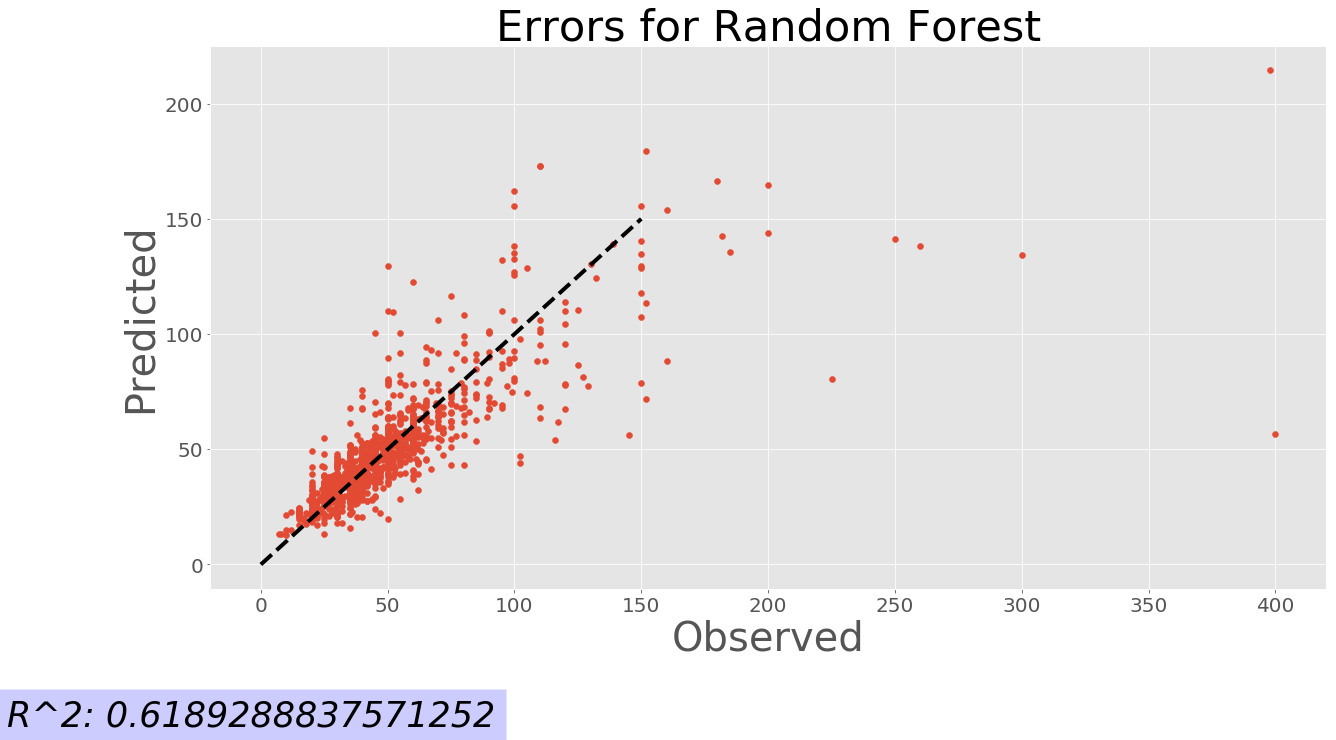

In [78]:
import matplotlib
from sklearn.metrics import r2_score

matplotlib.rcParams.update({'font.size': 30})
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Create linear regression object for predicted vs measured
error_reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(predicted)

# Train the model using the training sets
error_reg.fit(x, y)

r2 = r2_score(test['rent_per_week'], predicted)

# The coefficients
print('Slope of regression line for obs v pred: ', error_reg.coef_)
print("mean_absolute_error: {}".format(mean_absolute_error(test['rent_per_week'], predicted)))
print("R^2:  {}".format(r2))
      
# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = predicted)
stopping_value = 150
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4, color="black")
ax.set_title('Errors for Random Forest')
ax.set_xlabel('Observed', fontsize=40)
ax.set_ylabel('Predicted', fontsize=40)
#ax.plot(x, error_reg.predict(x), 'k--', color='black', linewidth=3)

ax.text(-100, -70, 'R^2: {}'.format(r2), style='italic', fontsize=35,
bbox={'facecolor':'blue', 'alpha':0.2, 'pad':10})

x = test['rent_per_week']
df_full_test['predicted_rent'] = predicted
#df_full_test['error'] = df_full_test[['rent_per_week', 'predicted_rent']].subtract(axis=1)
df_full_test['error'] = df_full_test['rent_per_week'] - df_full_test['predicted_rent']
df_full_test['abs_error'] = np.abs(df_full_test['rent_per_week'] - df_full_test['predicted_rent'])
print("Length of df_full_test: {}".format(len(df_full_test)))
#df_full_test['error'] = df_full_test['error'].abs()

# calculate number of items within a certain range
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
print(len(num_low_errors))

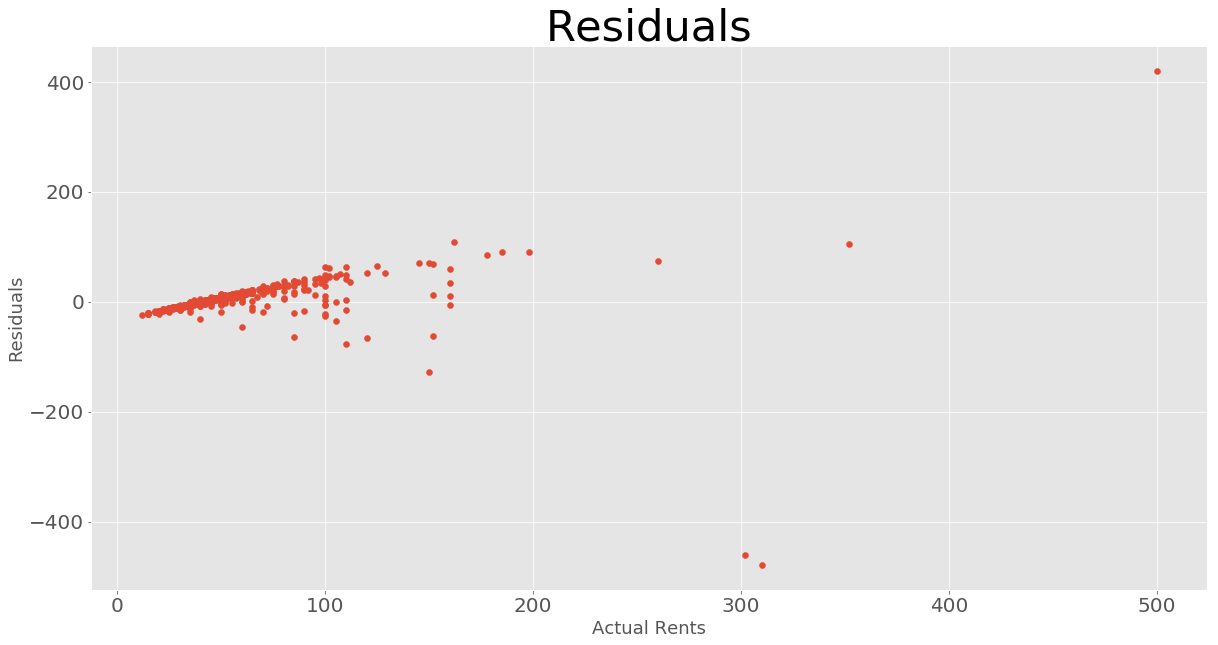

In [56]:
fig, ax = plt.subplots(figsize=(20, 10))
df_error = df_full_test.loc[df_full_test['error']>0][['brand', 'item_type', 'title', 'error', 'description']].sort_values('error', ascending = 0)
ax.scatter(df_full_test['rent_per_week'], df_full_test['error'].values)
ax.set_title('Residuals')
ax.set_ylabel('Residuals', fontsize=18)
ax.set_xlabel('Actual Rents', fontsize=18)

In [57]:
pd.set_option('display.max_colwidth', -1)

#d_errors = df_error.sort_values('error', ascending=False)
binwidth = 50
bins = list(range(0, 1000 + binwidth, binwidth))
l = []
#for i in bins:
#    y = len(d[d['error'] < i+1]) & (d[d['error'] >= i]))
#    x = i
#    l.append((x,y))
#lower = 0
#upper = 50
#d_errors = df_error.sort_values('error', ascending=True)
#num_high_errors = d_errors[(d_errors['error'] > 30) & (d_errors['error'] < 1000)]
#len(num_high_errors)
#num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 10)]
#print(len(num_low_errors)/len(num_high_errors))
#print(len(num_low_errors)/len(d_errors))
#print(len(num_low_errors))
d_errors = df_full_test
num_low_errors = d_errors[(d_errors['error'] > 0) & (d_errors['error'] < 20)]
num_high_errors = d_errors[(d_errors['error'] > 20) & (d_errors['error'] < 1000)]
print(len(num_low_errors))
print(len(num_high_errors))

# grouping errors wasn't working
d_errors = df_full_test.sort_values('error', ascending=True)
grps = d_errors.groupby('brand')
grps.first()

402
84


,item_type,title,cost,rent_per_week,description,brand_freq,is_train,predicted_rent,error,abs_error
brand,,,,,,,,,,
14510 Zoe,dresses,Ruffle Maxi Gown,595.00,70.0,One shoulder ruffle tiered gown in an off-white silk,4,False,47.790003,22.209997,22.209997
360 SWEATER,dresses,Dakoda Dress,275.00,43.0,A curved hem cuts a flattering line on this A-line 360 SWEATER dress.,2,False,39.873882,3.126118,3.126118
5 & Mercer,dresses,Long Sleeve Dress,250.00,35.0,Long sleeve dress in saphhire blue with exposed zipper,2,False,39.313716,-4.313716,4.313716
5th & Mercer,dresses,Long Sleeve Dress,250.00,40.0,Tiny raised dots bring rich texture to this 5th & Mercer midi dress. 2-way exposed back zip.,2,False,39.313716,0.686284,0.686284
A.L.C,dresses,Ali Dress,465.00,50.0,"Stretch fit with a bit of fit & flare. Composition: 86% rayon , 13% nylon , 1% elastane\n\n",2,False,44.400319,5.599681,5.599681
A.L.C.,dresses,Ryan Knit Dress,230.00,28.0,"Smooth, sleek knit silhouette with high crewneck, styled with a chic wrap skirt with press-stud buckled leather tab.",13,False,38.871255,-10.871255,10.871255
ABS,dresses,Just Amaze Dress,180.00,27.0,Perfect dress for your night out. Be unforgettable in this dress.,16,False,37.786766,-10.786766,10.786766
AD,dresses,Ponte Turtleneck Midi Dress,277.00,43.0,A turtleneck AD dress with curved seams. A back slit relaxes the tea-length hem.,2,False,39.919038,3.080962,3.080962
ALEXANDER MCQUEEN,dresses,Victorian Lace Knit Dress,1437.15,129.0,This white and pink Victorian Lace Knit Dress from Alexander Mcqueen is a bodycon dress you will definitely want to wear to your next holiday party. \n\nBrand New. You would be the first to wear it.,2,False,76.969365,52.030635,52.030635


In [58]:
df_error['brand'].drop_duplicates()

928     Katya Lee Designs        
5658    Ralph Lauren             
5760    Yves Saint Laurent       
2748    Jonathan Saunders        
4007    Thakoon                  
4483    Herve Leger              
3607    Dolce & Gabbana          
640     Lela Rose                
3448    BCBG                     
4685    Style Lend               
4868    Nicole Bakti             
3948    Mara Hoffman             
549     ALEXANDER MCQUEEN        
5423    St. John Collection      
614     Self Portrait            
5433    Roberto Cavalli          
4135    Badgley Mischka          
2345    Chanel                   
1694    Emilio Pucci             
402     Self-Portrait            
40      Notte by Marchesa        
1508    Elizabeth and James      
5424    RED Valentino            
3305    Tadashi Shoji            
562     Burberry                 
4405    Max Mara                 
5331    Sue Wong                 
5546    Rachel Zoe               
3943    Alexander McQueen        
746     Rachel

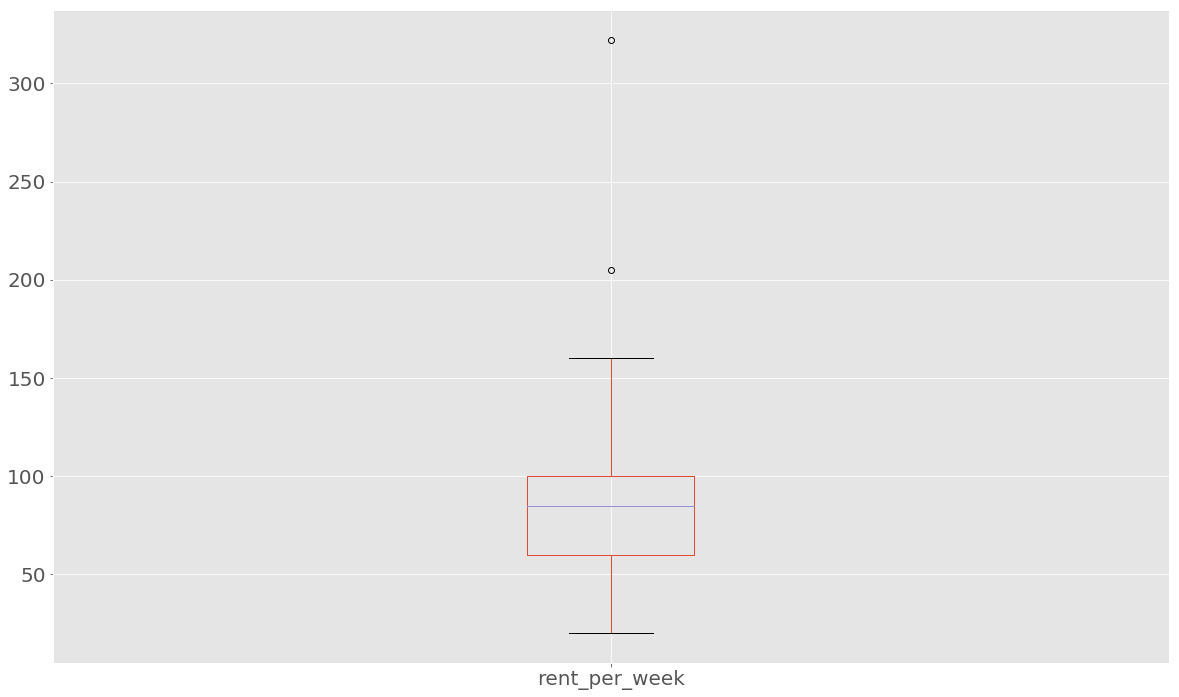

In [59]:
#new_df = df.loc[(df['rent_per_week'] < 1000) & (df['cost'] < 1000)].drop('id', 1).boxplot()
df_full = ml_model.canonical_df
ysl_v = df_full.loc[df_full['brand'] == 'Yves Saint Laurent'][['rent_per_week']].values
jm_v = df_full.loc[df_full['brand'] == 'J Mendel'][['rent_per_week']].values
chanel_v = df_full.loc[df_full['brand'] == 'chanel'][['rent_per_week']].values
chloe_v = df_full.loc[df_full['brand'] == 'chloe'][['rent_per_week']].values
# create a new column 'log_rent' which is just the log of rent
#def log_trans(x):
#    return np.log(x)

#df['log_rent'] = df['rent_per_week'].apply(log_trans)
df_dist = pd.DataFrame(['ysl_v, jm_v, chanel_v, chloe_v'], columns = ['Yves Saint Laurent, J Mendel, chanel, chloe'])
chanel_v = df_full.loc[df_full['brand'] == 'Chanel'][['rent_per_week']]

chloe_v = df_full.loc[df_full['brand'] == 'Chloè'][['rent_per_week']]
chanel_v.boxplot()

In [60]:
# create a new column 'log_rent' which is just the log of rent
#def log_trans(x):
#    return np.log(x)

df['log_rent'] = df['rent_per_week'].apply(np.log)
# drop columns that we don't want to use as features in our model
excluded_features = ['rent_per_week', 'title', 'cost', 'is_train', 'description', 'log_rent']
features = df.columns.drop(excluded_features)


# split one-hotted df into true and false subets
train, test = df[df['is_train']==True], df[df['is_train']==False]

reg.fit(train[features], train['log_rent'])
predicted = reg.predict(test[features])

model_dir = '/home/patrick/Dropbox/insight/wombat/wombat/engine/stat_model_pickles'
model_path = os.path.join(model_dir, 'rfr_v0.1_no_adj.pkl')
#joblib.dump(reg, model_path)
#call this with: clf = joblib.load('huber_v0.1.pkl')
print(test['log_rent'].values)
print(reg.predict(test[features]))
train[['rent_per_week', 'log_rent']]

[ 4.2341065   3.81771233  3.80666249  3.8918203   3.68887945  3.55534806
  4.70048037  3.68887945  3.91202301  4.17438727  4.00733319  3.80666249
  3.40119738  3.68887945  3.68887945  3.68887945  3.68887945  3.21887582
  3.68887945  3.40119738  3.68887945  3.91202301  4.00733319  3.55534806
  3.55534806  3.91202301  3.68887945  4.00733319  4.17438727  3.55534806
  3.55534806  3.91202301  4.31748811  4.24849524  4.09434456  3.91202301
  3.68887945  3.55534806  3.68887945  3.68887945  3.68887945  3.91202301
  4.02535169  3.55534806  3.80666249  3.80666249  3.68887945  4.00733319
  3.55534806  4.09434456  4.00733319  3.80666249  3.17805383  3.21887582
  3.52636052  3.68887945  3.55534806  4.09434456  3.55534806  3.80666249
  3.55534806  4.49980967  3.91202301  4.00733319  3.80666249  3.80666249
  2.99573227  3.91202301  4.07753744  4.24849524  3.55534806  4.00733319
  3.55534806  4.09434456  3.80666249  3.68887945  4.17438727  3.80666249
  2.99573227  3.40119738  3.40119738  3.40119738  2

,rent_per_week,log_rent
0,99.0,4.595120
3,33.9,3.523415
5,49.0,3.891820
6,89.0,4.488636
9,45.0,3.806662
11,35.0,3.555348
12,35.0,3.555348
14,35.0,3.555348
16,40.0,3.688879
18,30.0,3.401197


R^2: 
 0.00590770572293


NameError: name 'plt2' is not defined

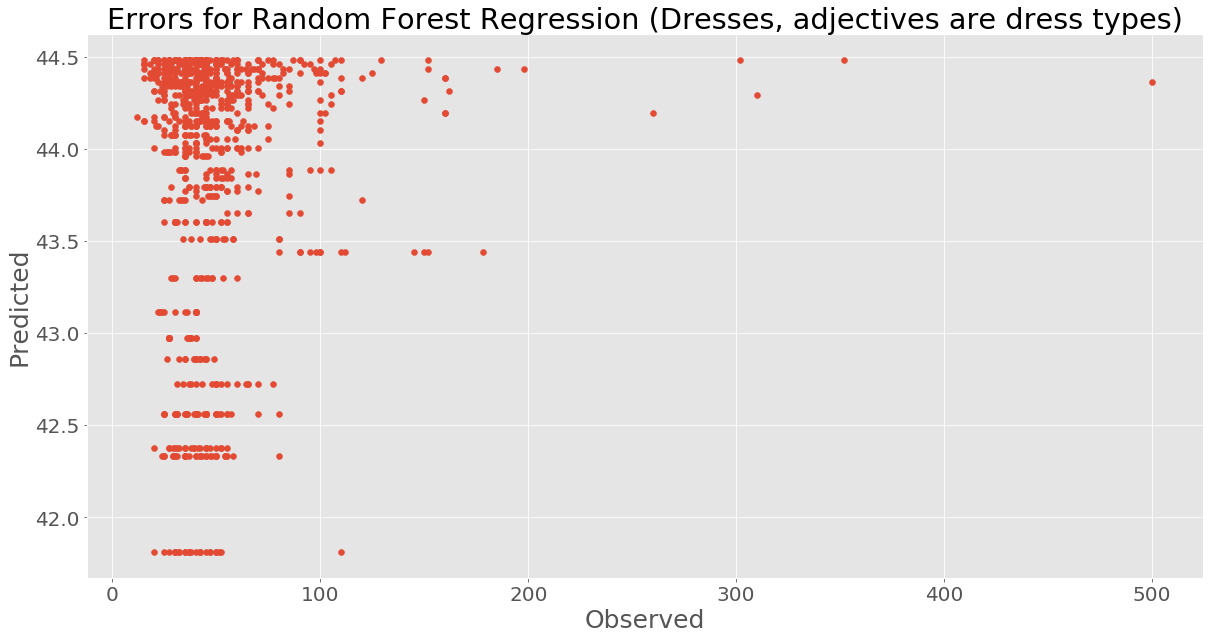

In [61]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as log_plt

print('R^2: \n', r2_score(test['log_rent'].values, reg.predict(test[features])))

# Plot outputs
#matplotlib.rc('xtick', labelsize=30) 
#matplotlib.rc('ytick', labelsize=30) 
matplotlib.rcParams.update({'font.size': 20})
fig, ax = log_plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = np.exp(reg.predict(test[features])))
stopping_value = 300
#ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4, color="blue")
ax.set_title('Errors for Random Forest Regression (Dresses, adjectives are dress types)')
ax.set_xlabel('Observed', fontsize=25)
ax.set_ylabel('Predicted', fontsize=25)
#ax.plot(x, error_reg.predict(x), 'k--', color='black', linewidth=3)

plt2.show()
print(test['log_rent'].values)
print(reg.predict(test[features]))

In [ ]:
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 50})
fig, ax = log_plt.subplots(figsize=(20, 10))
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40) 

stopping_value = 300
#ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4, color="blue")
ax.set_title('All Items')
ax.set_ylabel('# of Items', fontsize=60)
ax.set_xlabel('Rental price per week', fontsize=60)
#ax.plot(x, error_reg.predict(x), 'k--', color='black', linewidth=3)

rents = df['rent_per_week'].values
rents_log = df['rent_per_week'].apply(np.log).values

ax.hist(x = rents, bins=30)